# Behind the Grades: Mental Health Trends in Indian Students


## 1. Motivation

In [2]:
# Import necessary libraries
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, pointbiserialr
import folium
from folium import CircleMarker
import branca.colormap as cm
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Select, FactorRange, CustomJS
from bokeh.plotting import figure
from bokeh.io import output_file, save

# Download the dataset using kagglehub
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset") 
print("Path to dataset files:", path)
print("Files in dataset:", os.listdir(path))
csv_path = os.path.join(path, "student_depression_dataset.csv")
df = pd.read_csv(csv_path)

Path to dataset files: C:\Users\UPASANA\.cache\kagglehub\datasets\adilshamim8\student-depression-dataset\versions\1
Files in dataset: ['student_depression_dataset.csv']


Our project explores the Student Depression Dataset from Kaggle, which contains survey responses from approximately 28,000 university students across India. The dataset provides comprehensive insights into student mental health, including 18 different metrics for each student: depression status, academic performance (CGPA), lifestyle habits (sleep patterns, social media usage), basic demographics (age, gender), and important mental health indicators (presence of suicidal thoughts, family history of mental illness). This well-structured information allows us to analyze both the prevalence and potential causes of depression among Indian students.

We selected this dataset because student mental health represents a critical yet frequently overlooked issue. With more than 60% of students in the dataset reporting depression symptoms, we identified an important opportunity to illuminate the challenges that exist beneath the surface of academic achievement. Being students ourselves, we relate to these difficulties and wanted to develop visualizations that could help others identify warning signs and better understand the various factors that influence mental wellbeing in educational environments.

Our main objective was to create an accessible narrative that effectively communicates the complex nature of student mental health. Rather than presenting only statistics, we aimed to convey the real human experiences behind the numbers. Through clear visualizations and thoughtful analysis, we sought to demonstrate how factors such as academic pressure, sleep quality, and social media habits connect with depression. By designing our website as a progressive journey from basic statistics to more nuanced relationships, we intended to create a resource valuable to educators, parents, and students alike, potentially contributing to increased awareness and improved support systems.

## 2. Basic stats

In [3]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

The dataset contains **27,901 entries** and **18 columns**. Each row represents an individual student's response to a mental health survey, covering aspects such as academic stress, lifestyle habits, and mental health indicators. There are **no missing values** in any of the columns, which simplifies preprocessing.

- **Numerical (`float64` and `int64`)**:
  - `Age`, `Academic Pressure`, `Work Pressure`, `CGPA`, `Study Satisfaction`, `Job Satisfaction`, `Work/Study Hours`
  - `Depression` (target: binary 0/1), `id`

- **Categorical (`object`)**:
  - `Gender`, `City`, `Profession`, `Sleep Duration`, `Dietary Habits`, `Degree`
  - `Have you ever had suicidal thoughts ?`, `Financial Stress`, `Family History of Mental Illness`

This combination of quantitative and qualitative data supports both statistical analysis and rich visual exploration.

####  Data Cleaning and Preprocessing

While the dataset is complete, several preprocessing steps were needed to prepare it for analysis:

1. **Binary Conversion**  
   To enable numerical comparison, `Yes`/`No` responses were mapped to binary values:
   - `Have you ever had suicidal thoughts ?` → `Suicidal_Thoughts`
   - `Family History of Mental Illness`  
   ```python
   {"Yes": 1, "No": 0}

2. **Ordinal Encoding**  

- **Financial stress**
 ```python
   {"Low": 1, "Medium": 2, "High": 3}
```
- **Sleep duration**
 ```python
   {
    "Less than 5 hours": 4,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9
}
```
- **Financial stress**
 ```python
   {"Low": 1, "Medium": 2, "High": 3}
```
2. **Column Renaming**  
Long column names like "Have you ever had suicidal thoughts ?" were renamed to Suicidal_Thoughts for simplicity in coding and plotting.




### Data Cleaning and Preprocessing:
While the dataset is complete with no missing values, several preprocessing steps were needed to prepare it for analysis:

In [4]:
df_clean = df.copy()

# binary conversion: convert 'Yes'/'No' to 1/0
df_clean['Suicidal_Thoughts'] = df_clean['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
df_clean['Family_History'] = df_clean['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

# ordinal encoding: map 'Financial Stress' to numeric 
financial_stress_map = {'Low': 1, 'Medium': 2, 'High': 3}
df_clean['Financial_Stress_Score'] = df_clean['Financial Stress'].map(financial_stress_map)

# map 'Sleep Duration' to estimated hours
sleep_duration_map = {
    'Less than 5 hours': 4,
    '5-6 hours': 5.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 9
}
df_clean['Sleep_Hours'] = df_clean['Sleep Duration'].map(sleep_duration_map)

# rename columns
df_clean.rename(columns={
    'Work/Study Hours': 'Work_Study_Hours',
    'Job Satisfaction': 'Job_Satisfaction',
    'Study Satisfaction': 'Study_Satisfaction',
    'Academic Pressure': 'Academic_Pressure',
    'Work Pressure': 'Work_Pressure',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Sleep Duration': 'Sleep_Duration',
    'Dietary Habits': 'Dietary_Habits',
    'Financial Stress': 'Financial_Stress',
    'Family History of Mental Illness': 'Family_History',
}, inplace=True)


print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      27901 non-null  int64  
 1   Gender                  27901 non-null  object 
 2   Age                     27901 non-null  float64
 3   City                    27901 non-null  object 
 4   Profession              27901 non-null  object 
 5   Academic_Pressure       27901 non-null  float64
 6   Work_Pressure           27901 non-null  float64
 7   CGPA                    27901 non-null  float64
 8   Study_Satisfaction      27901 non-null  float64
 9   Job_Satisfaction        27901 non-null  float64
 10  Sleep_Duration          27901 non-null  object 
 11  Dietary_Habits          27901 non-null  object 
 12  Degree                  27901 non-null  object 
 13  Suicidal_Thoughts       27901 non-null  object 
 14  Work_Study_Hours        27901 non-null

### One-Hot Encoding
We convert categorical features like Gender and Profession into numeric form using one-hot encoding.

In [5]:
# one-hot encode 'Gender' and 'Profession'
df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Profession'], drop_first=True)
print(df_encoded.columns)
print(df_encoded.info())
print(df_encoded.head())
#df_encoded.to_csv("student_depression_cleaned.csv", index=False)

Index(['id', 'Age', 'City', 'Academic_Pressure', 'Work_Pressure', 'CGPA',
       'Study_Satisfaction', 'Job_Satisfaction', 'Sleep_Duration',
       'Dietary_Habits', 'Degree', 'Suicidal_Thoughts', 'Work_Study_Hours',
       'Financial_Stress', 'Family_History', 'Depression', 'Suicidal_Thoughts',
       'Family_History', 'Financial_Stress_Score', 'Sleep_Hours',
       'Gender_Male', 'Profession_'Content Writer'',
       'Profession_'Digital Marketer'', 'Profession_'Educational Consultant'',
       'Profession_'UX/UI Designer'', 'Profession_Architect',
       'Profession_Chef', 'Profession_Doctor', 'Profession_Entrepreneur',
       'Profession_Lawyer', 'Profession_Manager', 'Profession_Pharmacist',
       'Profession_Student', 'Profession_Teacher'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               ---

## 3. Data Analysis
Our analysis uncovered significant relationships between various lifestyle factors and the prevalence of depression among Indian university students. Some of the most notable findings include:


### Mental Health Risk Distribution Among Students

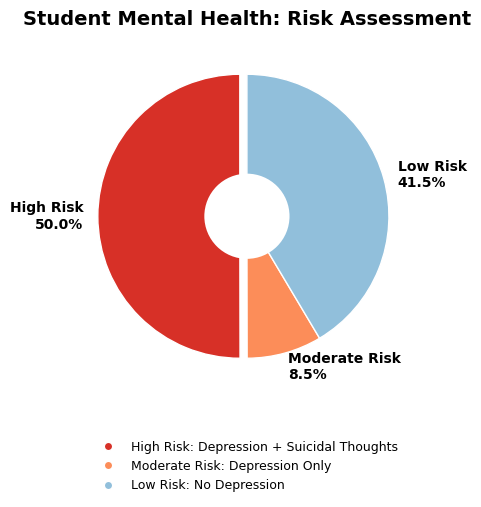

In [6]:

plt.figure(figsize=(5, 5))

# Define the main statistics to highlight
total_students = len(df)
depressed_count = df['Depression'].sum()
depressed_percent = round((depressed_count / total_students * 100), 1)

# Count students in each risk category
high_risk_count = df[(df['Depression'] == 1) & 
                     (df['Have you ever had suicidal thoughts ?'] == 'Yes')].shape[0]
high_risk_percent = round((high_risk_count / total_students * 100), 1)

moderate_risk_count = df[(df['Depression'] == 1) & 
                         (df['Have you ever had suicidal thoughts ?'] == 'No')].shape[0]
moderate_risk_percent = round((moderate_risk_count / total_students * 100), 1)

low_risk_count = total_students - high_risk_count - moderate_risk_count
low_risk_percent = round((low_risk_count / total_students * 100), 1)

# Data for pie chart
sizes = [high_risk_count, moderate_risk_count, low_risk_count]
labels = [f'High Risk\n{high_risk_percent}%',
         f'Moderate Risk\n{moderate_risk_percent}%',
         f'Low Risk\n{low_risk_percent}%']
colors = ['#d73027', '#fc8d59', '#91bfdb']
explode = (0.05, 0, 0)

# Create pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='',
       startangle=90, explode=explode,
       wedgeprops={'edgecolor': 'white', 'linewidth': 1},
       textprops={'fontsize': 10, 'fontweight': 'bold'})

# Add title with Life Risk focus
plt.title('Student Mental Health: Risk Assessment',
         fontsize=14, fontweight='bold', pad=10)

circle = plt.Circle((0,0), 0.3, fc='white')
plt.gca().add_artist(circle)

plt.subplots_adjust(bottom=0.17)  # Add more room at the bottom

# Create a custom legend outside the axis area
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#d73027', markersize=6, 
              label='High Risk: Depression + Suicidal Thoughts'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#fc8d59', markersize=6, 
              label='Moderate Risk: Depression Only'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#91bfdb', markersize=6, 
              label='Low Risk: No Depression')
]

# Position the legend closer to the bottom of the chart
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.10), 
         ncol=1, frameon=False, fontsize=9)

# Save the plot to the plots folder with tight bbox but preserving the bottom margin
plt.savefig("plots/Pie_chart_mental_health_risk.png", dpi=300, bbox_inches='tight', 
           pad_inches=0.2)
plt.show()

### Distribution of Numeric Features

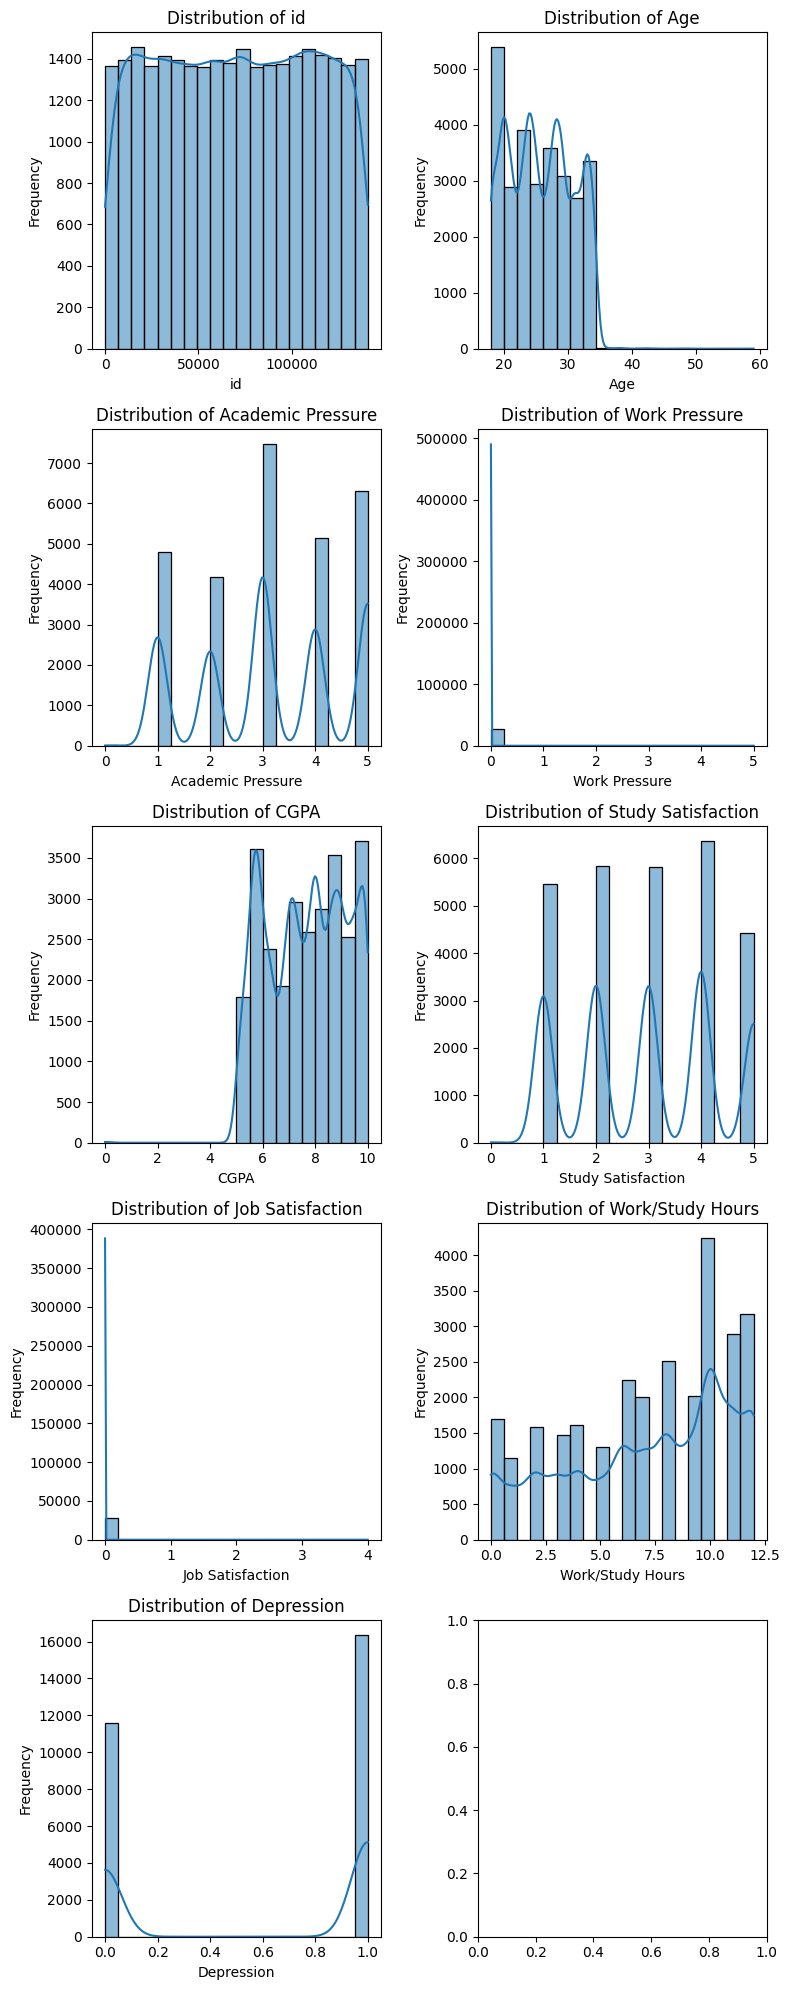

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_cols=df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=df.select_dtypes(include=['object']).columns.tolist()

n=len(num_cols)
cols=2
rows=math.ceil(n/cols)
fig,axes=plt.subplots(rows,cols,figsize=(cols*4,rows*4))
axes=axes.flatten()

for i , col in enumerate(num_cols):
    sns.histplot(df[col],kde=True,ax=axes[i],bins=20)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(f"plots/{col}-distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of Categorical Features

### Regional Variation

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\2661375801.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=90)
C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\2661375801.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=90)
C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\2661375801.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=90)
C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\2661375801.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set

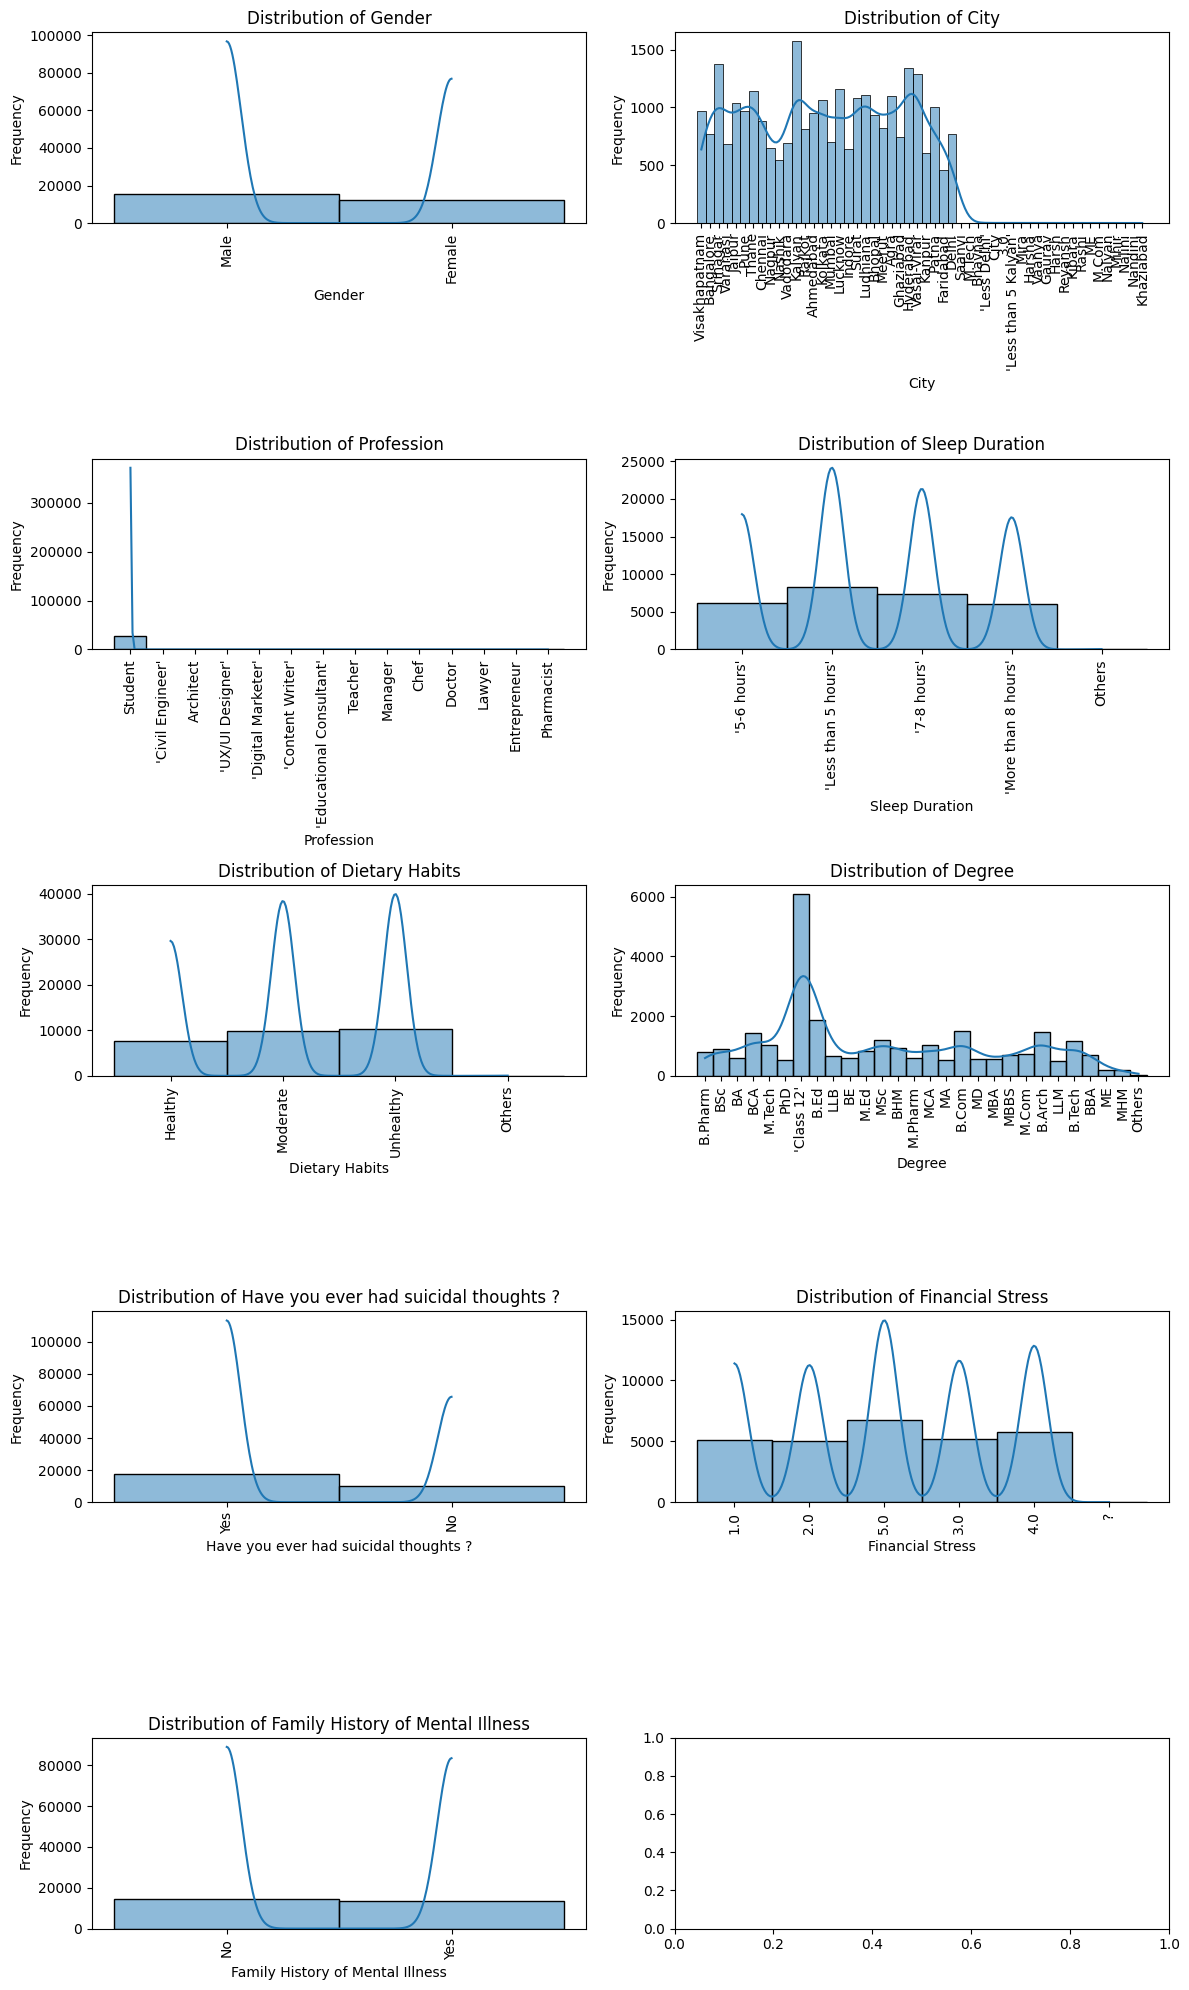

In [8]:
n=len(cat_cols)
cols=2
rows=math.ceil(n/cols)
fig,axes=plt.subplots(rows,cols,figsize=(cols*6,rows*4))
axes=axes.flatten()

for i , col in enumerate(cat_cols):
    sns.histplot(df[col],kde=True,ax=axes[i],bins=20)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=90)
plt.tight_layout()
plt.savefig(f"plots/{col}-distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### Top 10 Cities with Most Student Responses

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\1012865723.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='Paired')


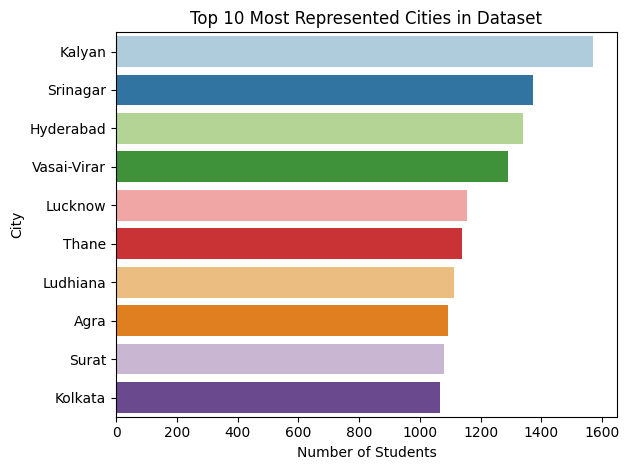

In [9]:
top_cities = df['City'].value_counts().nlargest(10)
sns.barplot(x=top_cities.values, y=top_cities.index, palette='Paired')
plt.title("Top 10 Most Represented Cities in Dataset")
plt.xlabel("Number of Students")
plt.ylabel("City")
plt.tight_layout()
plt.savefig("plots/top_cities.png", dpi=300)


### Feature Correlation Strength with Depression

Feature: Sleep Duration
Chi-square statistic: 276.8483796551745, p-value: 1.065310789284643e-58

Cramér's V: 0.09961187351493382

Feature: Dietary Habits
Chi-square statistic: 1202.6381759497453, p-value: 1.9624854819352487e-260

Cramér's V: 0.2076144648816412

Feature: Academic Pressure
Correlation coefficient: 0.47483494398066267, p-value: 0.0

Feature: Study Satisfaction
Correlation coefficient: -0.16797138380307755, p-value: 1.1683786807171434e-175

Feature: Financial Stress
Correlation coefficient: 0.3635914288437023, p-value: 0.0

Feature: CGPA
Correlation coefficient: 0.02226765807500976, p-value: 0.00019954376212920062

Feature: Work/Study Hours
Correlation coefficient: 0.20862715565066636, p-value: 6.21313145896095e-272



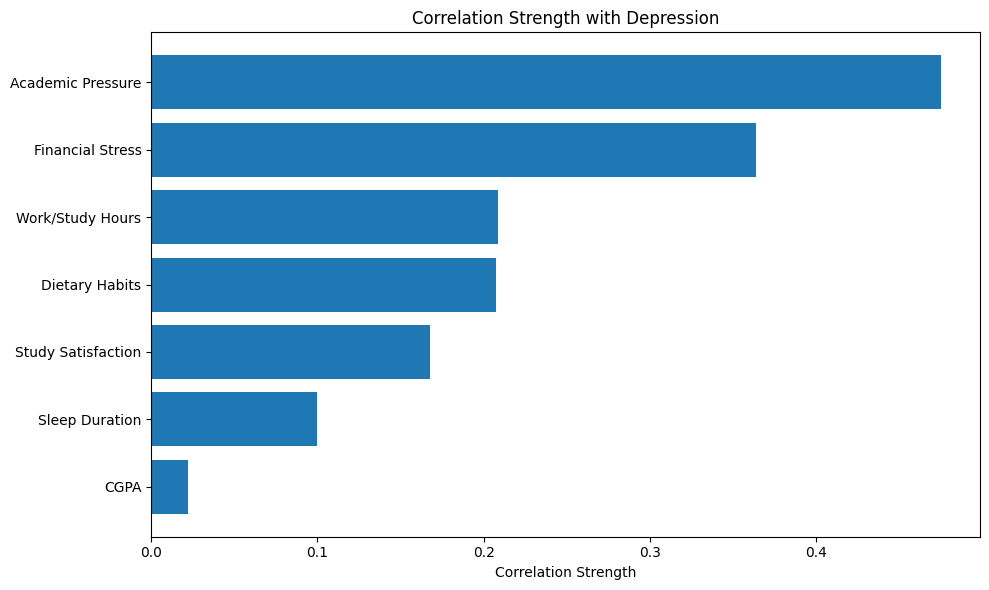

In [11]:
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt


correlation_strenght = pd.DataFrame(columns=["Feature", "Correlation Strength"])
numerical_features = ['Academic Pressure', 'Study Satisfaction', 'Financial Stress', 'CGPA', 'Work/Study Hours' ]
categorical_features = [ 'Sleep Duration', 'Dietary Habits']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Depression'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    cramers_v_value = cramers_v(df[feature], df['Depression'])
    print(f'Feature: {feature}')
    print(f'Chi-square statistic: {chi2}, p-value: {p}\n')
    print(f"Cramér's V: {cramers_v_value}\n")
    correlation_strenght.loc[-1] = [feature, abs(cramers_v_value)]
    correlation_strenght.index = correlation_strenght.index + 1

for feature in numerical_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
    df = df.dropna(subset=[feature, 'Depression'])
    correlation, p_value = pointbiserialr(df[feature], df['Depression'])
    print(f'Feature: {feature}')
    print(f'Correlation coefficient: {correlation}, p-value: {p_value}\n')
    correlation_strenght.loc[-1] = [feature, abs(correlation)]
    correlation_strenght.index = correlation_strenght.index + 1

correlation_strenght = correlation_strenght.sort_values(by="Correlation Strength", ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(correlation_strenght['Feature'], correlation_strenght['Correlation Strength'])
plt.xlabel('Correlation Strength')
plt.title('Correlation Strength with Depression')
plt.tight_layout()
plt.savefig("correlation_strength.png")


## 4. Genre:

For our project on student depression, we chose a **magazine-style narrative** combined with **annotated charts** to communicate our findings in a clear and engaging way.

### Visual Narrative (Segel & Heer)

- **Visual Structuring: Consistent Visual Platform**  
  We maintained a consistent visual design throughout the article, changing only the content across sections. This uniformity reinforces a serious and professional tone appropriate for the sensitive and important topic we address.

- **Highlighting: Feature Distinction**  
  To draw attention to key takeaways from the data, we used bold text for emphasis and positioned charts and maps centrally on the page. This visual choice helps to focus on the most critical insights.

- **Transition Guidance: Familiar Objects**  
  We ensured consistency in plot styles, such as using the same color schemes and layouts across charts. This approach creates a smoother reading experience by helping readers stay oriented as they move from one section to the next.

### Narrative Structure

- **Ordering: Linear**  
  Our article follows a linear structure, beginning with an introduction to the topic, followed by data-driven explanatory sections, and concluding with a summary. This straightforward progression supports a clear and coherent narrative flow.

- **Interactivity: Very Limited Interactivity**  
  While most of our visualizations are static to keep the focus on core messages, we included one interactive plot that allows readers to explore how various factors contribute to student depression. This balances informative depth with simplicity.

- **Messaging: Accompanying Article, Captions/Headlines, Summary/Synthesis**  
  As our project adopts a traditional article format, we use standard messaging elements such as section headlines, informative captions, and explanatory text. A concluding summary synthesizes the main points, ensuring that the reader leaves with a clear understanding of the data story.


## 5. Visualizations 

### Number of Students With and Without Depression

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\3622771745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_encoded, x='Depression', palette='pastel')


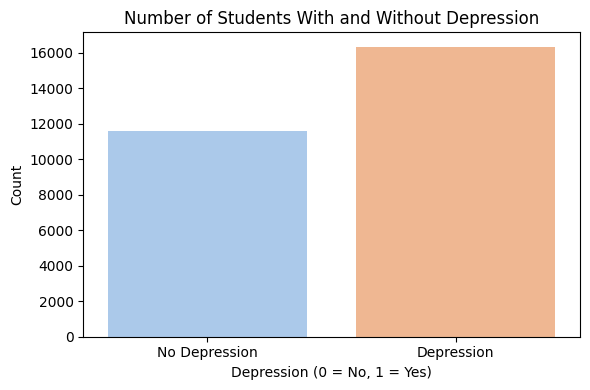

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_encoded, x='Depression', palette='pastel')
plt.title("Number of Students With and Without Depression")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Depression", "Depression"])
plt.tight_layout()
plt.show()


### Depression Rate Among Students – Proportional View

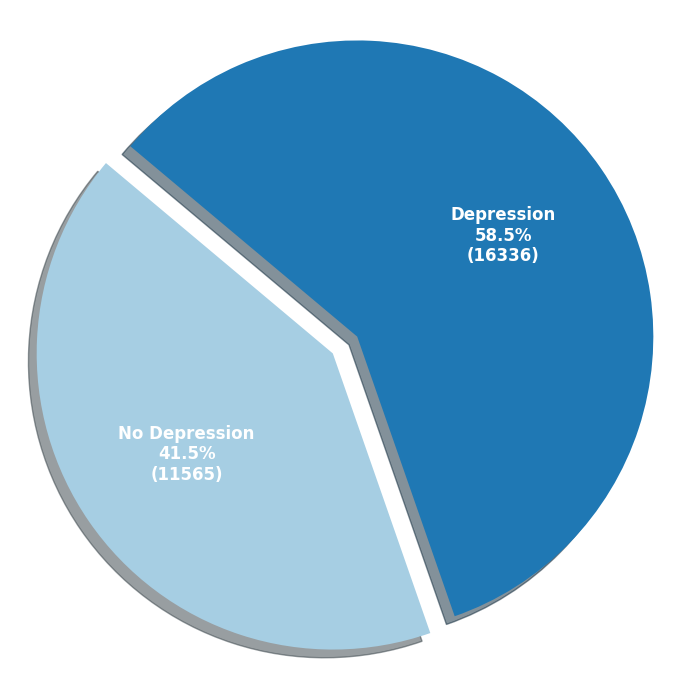

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

depression_counts = df_encoded['Depression'].value_counts().sort_index()
labels = ['No Depression', 'Depression']  
values = depression_counts.tolist()

colors = sns.color_palette('Paired')[:2]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    values,
    labels=None,
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

for i, (wedge, autotext) in enumerate(zip(wedges, autotexts)):
    label = labels[i]
    count = values[i]
    percentage = autotext.get_text()
    
    autotext.set_text(f"{label}\n{percentage}\n({count})")
    
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

for text in texts:
    text.set_text("")

#plt.title("Proportion of Students With and Without Depression", fontsize=14, weight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig("plots/depression_pie_chart.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Student Ages:

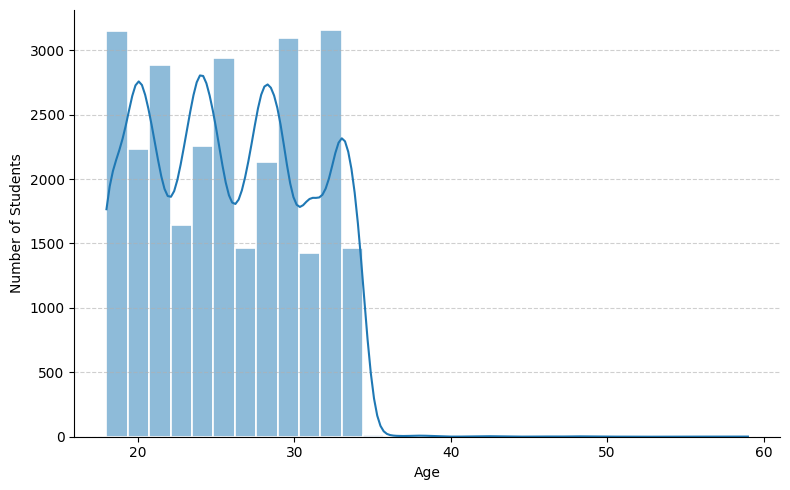

In [14]:
paired_color = sns.color_palette('Paired')[1] 

plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=30, kde=True, color=paired_color, edgecolor='white', linewidth=1.2)

#plt.title("Distribution of Student Ages", fontsize=14, weight='bold', pad=10)
plt.xlabel("Age")
plt.ylabel("Number of Students")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.savefig("plots/age_distribution.png", dpi=300, bbox_inches='tight')

plt.show()



In [ ]:
# Load cities data for geographical coordinates

print(cities_df.columns)
print(cities_df.head())

# Calculate depression rates by city
city_depression_counts = df[df['Depression'] == 1].groupby('City').size().reset_index(name='Depressed_Count')
city_total_counts = df.groupby('City').size().reset_index(name='Total_Students')
city_stats = pd.merge(city_total_counts, city_depression_counts, on='City', how='left')
city_stats['Depressed_Count'].fillna(0, inplace=True)
city_stats['Depression_Rate'] = city_stats['Depressed_Count'] / city_stats['Total_Students']

# Merge with city coordinates
city_coords = cities_df[['City', 'Lat', 'Long']].drop_duplicates()
city_map_df = pd.merge(city_stats, city_coords, on='City', how='inner')

# Create choropleth map
# Clean city names
df['City'] = df['City'].str.strip().str.title()
cities_df['City'] = cities_df['City'].str.strip().str.title()

# Create map
m = folium.Map(location=[22.5, 78.9], zoom_start=5, tiles='CartoDB positron')

# Create a color scale (0 to 1)
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'orange', 'red', 'darkred'],
    vmin=0, vmax=1,
    caption='Depression Rate'
)

for _, row in city_map_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5 + (row['Depression_Rate'] * 15),
        popup=(f"<b>{row['City']}</b><br>"
               f"Depression Rate: {row['Depression_Rate']:.1%}<br>"
               f"Total Students: {int(row['Total_Students'])}"),
        color=colormap(row['Depression_Rate']),
        fill=True,
        fill_color=colormap(row['Depression_Rate']),
        fill_opacity=0.75
    ).add_to(m)

m.save("city_depression_map_choropleth.html")
print("✅ Map saved as 'city_depression_map_choropleth.html'")

NameError: name 'cities_df' is not defined

### Gender Distribution of Surveyed Students

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\1364530096.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Gender', palette='Paired', edgecolor='white')


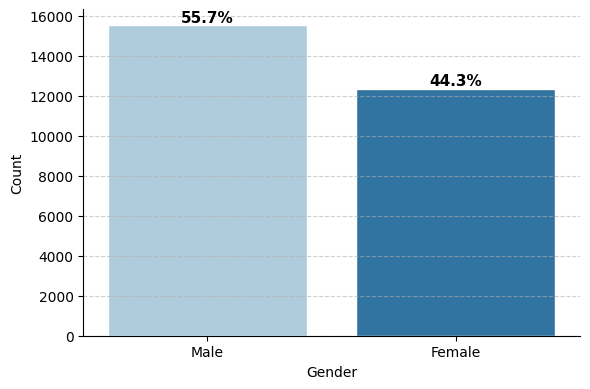

In [17]:
import numpy as np

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Gender', palette='Paired', edgecolor='white')
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percent = f'{100 * height / total:.1f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, weight='bold',)

#plt.title("Gender Distribution Among Students", fontsize=14, weight='bold', pad=10)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.savefig("plots/gender_distribution.png", dpi=300, bbox_inches='tight')

plt.show()



### Depression Rate Across Indian Cities – Marker Map

In [18]:
cities_df = pd.read_csv("indian_cities.csv")
print(cities_df.columns)
print(cities_df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'indian_cities.csv'

In [19]:
city_depression_counts = df[df['Depression'] == 1].groupby('City').size().reset_index(name='Depressed_Count')

city_total_counts = df.groupby('City').size().reset_index(name='Total_Students')

city_stats = pd.merge(city_total_counts, city_depression_counts, on='City', how='left')
city_stats['Depressed_Count'].fillna(0, inplace=True)

city_stats['Depression_Rate'] = city_stats['Depressed_Count'] / city_stats['Total_Students']

city_coords = cities_df[['City', 'Lat', 'Long']].drop_duplicates()

city_map_df = pd.merge(city_stats, city_coords, on='City', how='inner')



C:\Users\UPASANA\AppData\Local\Temp\ipykernel_28376\184102395.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  city_stats['Depressed_Count'].fillna(0, inplace=True)


NameError: name 'cities_df' is not defined

In [ ]:
import folium
from folium import CircleMarker

m = folium.Map(location=[22.5, 78.9], zoom_start=5, tiles='CartoDB positron')

for _, row in city_map_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5 + (row['Depression_Rate'] * 20), 
        popup=(f"<b>{row['City']}</b><br>"
               f"Depression Rate: {row['Depression_Rate']:.1%}<br>"
               f"Total Students: {int(row['Total_Students'])}"),
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.7
    ).add_to(m)

m.save("depression_map_india.html")


In [ ]:
import pandas as pd
import folium
from folium import CircleMarker
import branca.colormap as cm


df = pd.read_csv("student_depression_cleaned.csv")
cities = pd.read_csv("indian_cities.csv")

# Clean city names
df['City'] = df['City'].str.strip().str.title()
cities['City'] = cities['City'].str.strip().str.title()

# Aggregate depression data by city
city_depressed = df[df['Depression'] == 1].groupby('City').size().reset_index(name='Depressed')
city_total = df.groupby('City').size().reset_index(name='Total')

# Merge stats
city_stats = pd.merge(city_total, city_depressed, on='City', how='left')
city_stats['Depressed'] = city_stats['Depressed'].fillna(0)
city_stats['Rate'] = city_stats['Depressed'] / city_stats['Total']

# Merge with coordinates
city_coords = cities[['City', 'Lat', 'Long']].drop_duplicates()
city_map_df = pd.merge(city_stats, city_coords, on='City', how='inner')

import folium

m = folium.Map(location=[22.5, 78.9], zoom_start=5, tiles='CartoDB positron')



# Create a color scale (0 to 1)
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'orange', 'red', 'darkred'],
    vmin=0, vmax=1,
    caption='Depression Rate'
)


for _, row in city_map_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5 + (row['Rate'] * 15),
        popup=(f"<b>{row['City']}</b><br>"
               f"Depression Rate: {row['Rate']:.1%}<br>"
               f"Total Students: {int(row['Total'])}"),
        color=colormap(row['Rate']),
        fill=True,
        fill_color=colormap(row['Rate']),
        fill_opacity=0.75
    ).add_to(m)

m.save("city_depression_map_choropleth.html")
print("✅ Map saved as 'city_depression_map_choropleth.html'")



✅ Map saved as 'city_depression_map_choropleth.html'


### Interactive Exploration of Depression % by Category

In [21]:
import pandas as pd
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Select, FactorRange, CustomJS
from bokeh.plotting import figure
from bokeh.io import output_file, save

df['Depression'] = df['Depression'].map({0: 'Not Depressed', 1: 'Depressed'})
categorical_columns = ['Academic Pressure', 'Study Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Work/Study Hours', 'Financial Stress']
df['Sleep Duration'] = df['Sleep Duration'].astype(str).str.strip().str.strip("'")
study_order = ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours', 'Others']
work_study_hours_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']
depression_levels = ['Not Depressed', 'Depressed']

def make_grouped_data(feature):
    df[feature] = df[feature].astype(str)
    df['Depression'] = df['Depression'].astype(str)
    counts = df.groupby([feature, 'Depression']).size().reset_index(name='count')
    total_per_category = counts.groupby(feature)['count'].transform('sum')
    counts['percent'] = counts['count'] / total_per_category * 100

    if feature == 'Sleep Duration':
        ordered_categories = study_order
    elif feature == 'Work/Study Hours':
        ordered_categories = work_study_hours_order
    else:
        ordered_categories = sorted(counts[feature].unique())

    factors = [(cat, dep) for cat in ordered_categories for dep in depression_levels]
    percents = []
    for cat, dep in factors:
        match = counts[(counts[feature] == cat) & (counts['Depression'] == dep)]
        percents.append(match.iloc[0]['percent'] if not match.empty else 0)

    return factors, percents

all_data = {}
for feature in categorical_columns:
    factors, percents = make_grouped_data(feature)
    all_data[feature] = {
        'x': factors,
        'percent': percents
    }

initial_feature = categorical_columns[0]
source = ColumnDataSource(data=all_data[initial_feature])

plot = figure(x_range=FactorRange(*all_data[initial_feature]['x']), height=500, width=1200,
              title=f"Depression % by {initial_feature}", toolbar_location=None, tools="")
plot.vbar(x='x', top='percent', width=0.8, source=source)
plot.yaxis.axis_label = "% of students per category"
plot.xaxis.major_label_orientation = 1.2

select = Select(title="Select Feature", value=initial_feature, options=categorical_columns)

select.js_on_change("value", CustomJS(
    args=dict(source=source, plot=plot, all_data=all_data),
    code="""
        const feature = cb_obj.value;
        const data = all_data[feature];
        source.data = { x: data.x, percent: data.percent };
        plot.x_range.factors = data.x;
        plot.title.text = `Depression % by ${feature}`;
        source.change.emit();
    """
))

layout = column(select, plot)
output_file("depression_visualization.html")
save(layout)


'e:\\DTU\\Sem 2\\Social data Analysis\\02806_Final_Project.github.io\\depression_visualization.html'

## 6. Discussion

### What Went Well:
* Clean dataset: 
The dataset required minimal cleaning. There were no missing values, which allowed us to focus on analysis and visualization.

* Rich feature set: 
The dataset included both quantitative and qualitative variables (e.g., CGPA, sleep habits, diet, family mental health history), which enabled diverse and meaningful analyses.

* Effective visualizations: 
The combination of static (matplotlib, seaborn) and interactive (Bokeh, Folium) visualizations made our findings more engaging and user-friendly.

* Geographical insight: 
The use of interactive city-level depression maps added a spatial dimension to the analysis, offering new perspectives for policymakers and educators.

### What Is Still Missing:
* More detailed mental health labeling: The dataset uses a binary indicator for depression (0 = No, 1 = Yes), which limits the depth of analysis. If the survey had included a scaled rating (e.g., mild to severe), we could have explored the spectrum of mental health rather than treating it as a yes/no condition. This would improve the precision of our visualizations and statistical comparisons.

* Time-based insights: The data captures responses at a single point in time. Having even basic time information, such as academic year or semester, could help explore how mental health varies over the course of studies. Time-aware data could reveal trends related to exam seasons, workload peaks, or transition periods (e.g., first-year stress).

* Clarity in profession and degree fields: Some categories (like “Student” under Profession) are too broad. More detail about students' field of study, academic level (UG/PG), or course load would allow for more specific subgroup analysis and potentially highlight differences between disciplines or study types.


## 7. Contributions:


## 8. References:

* 1. Adil, S. (2023). Student Depression Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset
* 2. Heer, J., & Segal, E. (2010). Narrative Visualization: Telling Stories with Data. IEEE Transactions on Visualization and Computer Graphics, 16(6), 1139-1148. doi:10.1109/TVCG.2010.179